In [18]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [19]:
test_data = pd.read_csv('mnist_test.csv')

In [35]:
# Google Sheets Connect
scope = ["https://spreadsheets.google.com/feeds", "https://www.googleapis.com/auth/spreadsheets", "https://www.googleapis.com/auth/drive.file", "https://www.googleapis.com/auth/drive"]
creds = ServiceAccountCredentials.from_json_keyfile_name('creds.json', scope)
client = gspread.authorize(creds)
sheet = client.open("Handwritten-Dataset").sheet1

df = pd.DataFrame(sheet.get_all_values())
df.columns = df.iloc[0]
df = df[1:]
df = df.dropna()

In [36]:
for i in df.index: 
    df.at[i, "grid"] = df.at[i, "grid"].split(',')

In [37]:
x_data = []
y_data = df["label"]
for i in df.index:
    x_data.append(df.at[i,"grid"])
x_data = np.asarray(x_data).T
y_data = np.asarray(y_data)
x_data = x_data.astype('int32')
x_data = x_data / 255
y_data = y_data.astype('int32')

m, n = x_data.shape

In [38]:
x_data.shape

(784, 4)

In [39]:
y_data

array([3, 5, 4, 3])

In [40]:
def init_params():
    W1 = np.random.rand(10, 784) - 0.5
    b1 = np.random.rand(10, 1) - 0.5
    W2 = np.random.rand(10, 10) - 0.5
    b2 = np.random.rand(10, 1) - 0.5
    return W1, b1, W2, b2

def ReLU(Z):
    return np.maximum(Z, 0)

def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A
    
def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

def ReLU_deriv(Z):
    return Z > 0

def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2)
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1)
    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1    
    W2 = W2 - alpha * dW2  
    b2 = b2 - alpha * db2    
    return W1, b1, W2, b2

In [41]:
def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    print(predictions, Y)
    return np.sum(predictions == Y) / Y.size

def gradient_descent(X, Y, alpha, iterations):
    W1, b1, W2, b2 = init_params()
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        if i % 10 == 0:
            print("Iteration: ", i)
            predictions = get_predictions(A2)
            print(get_accuracy(predictions, Y))
    return W1, b1, W2, b2

In [42]:
data = np.array(test_data)
m, n = data.shape
np.random.shuffle(data) # shuffle before splitting into dev and training sets

data_dev = data[0:1000].T
Y_dev = data_dev[0]
X_dev = data_dev[1:n]
X_dev = X_dev / 255.

data_train = data[1000:m].T
Y_train = data_train[0]
X_train = data_train[1:n]
X_train = X_train / 255.
_,m_train = X_train.shape

In [43]:
X_train.shape
x_data.shape

(784, 4)

In [44]:
X_train = np.concatenate((x_data.T, X_train.T)).T
Y_train = np.concatenate((y_data.T, Y_train.T)).T

In [45]:
ytrain.shape

(9004,)

In [48]:
W1, b1, W2, b2 = gradient_descent(X_train, Y_train, 0.50, 100)

Iteration:  0
[3 3 3 ... 3 3 3] [3 5 4 ... 4 8 6]
0.11994669035984007
Iteration:  10
[1 2 6 ... 2 2 6] [3 5 4 ... 4 8 6]
0.40781874722345623
Iteration:  20
[3 4 2 ... 3 1 6] [3 5 4 ... 4 8 6]
0.5772989782318969
Iteration:  30
[3 4 2 ... 8 1 6] [3 5 4 ... 4 8 6]
0.6806974677920924
Iteration:  40
[3 6 4 ... 8 1 6] [3 5 4 ... 4 8 6]
0.6750333185251
Iteration:  50
[3 2 4 ... 8 1 6] [3 5 4 ... 4 8 6]
0.742225677476677
Iteration:  60
[3 2 4 ... 8 1 6] [3 5 4 ... 4 8 6]
0.7804309195912927
Iteration:  70
[3 2 4 ... 8 1 6] [3 5 4 ... 4 8 6]
0.7926477121279432
Iteration:  80
[3 2 4 ... 8 1 6] [3 5 4 ... 4 8 6]
0.812972012438916
Iteration:  90
[3 2 4 ... 8 1 6] [3 5 4 ... 4 8 6]
0.8249666814749


In [53]:
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

def test_prediction(index, W1, b1, W2, b2):
    current_image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None], W1, b1, W2, b2)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()



Prediction:  [4]
Label:  4


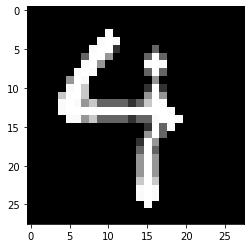

Prediction:  [2]
Label:  2


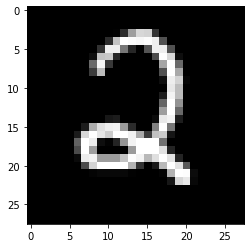

Prediction:  [4]
Label:  4


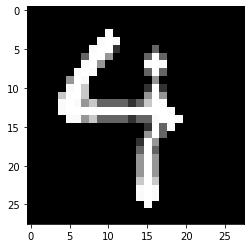

Prediction:  [3]
Label:  3


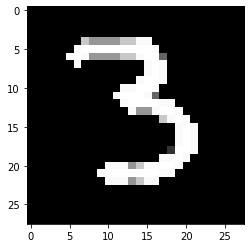

In [63]:
test_prediction(2, W1, b1, W2, b2)
test_prediction(6, W1, b1, W2, b2)
test_prediction(2, W1, b1, W2, b2)
test_prediction(3, W1, b1, W2, b2)